# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

OPTIMAL THRESHOLDING
Centroid 1 = 53.96054273827534, centroid 2 = 161.8508415183139, new threshold = 108
Centroid 1 = 33.93741927471436, centroid 2 = 155.7344183588072, new threshold = 95
Centroid 1 = 25.47344749560019, centroid 2 = 153.2091472054579, new threshold = 89
Centroid 1 = 23.449490442192538, centroid 2 = 152.53210637767813, new threshold = 88
Centroid 1 = 23.158285135916714, centroid 2 = 152.42777639597065, new threshold = 88
88


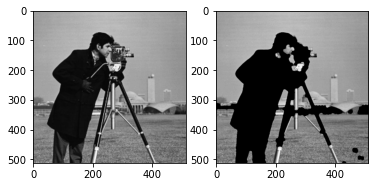

OTSU THRESHOLDING


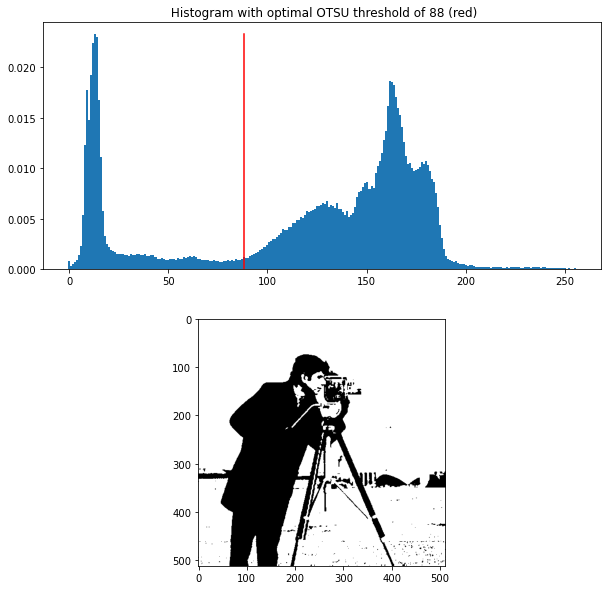

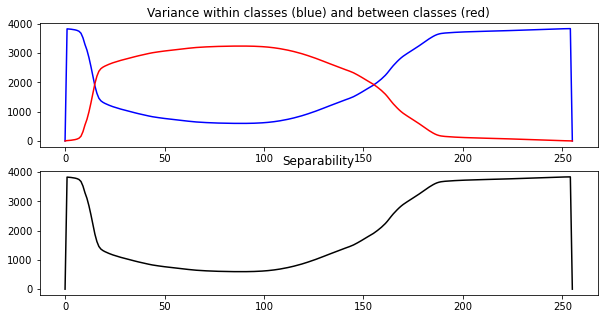

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow
from skimage.morphology import opening, closing, disk

def manual_threshold(im, T):
    return im>T

def optimal_threshold(im, T0):
    # Get histogram
    h, bins = np.histogram(im, range(257))

    # Divise distribution
    p1 = h[:T0]
    p2 = h[T0:]

    # Compute centroids
    
    c1 = (p1*np.arange(0, T0)).sum()/p1.sum()
    c2 = (p2*np.arange(T0, len(h))).sum()/p2.sum()

    # New threshold
    TX = int(round((c1+c2)/2))
    print(f'Centroid 1 = {c1}, centroid 2 = {c2}, new threshold = {TX}')
    if TX==T0:
        return TX
    else:
        return optimal_threshold(im, TX)

im = imread('camera.jpg')

print('OPTIMAL THRESHOLDING')


Topt = optimal_threshold(im, 127)
print(Topt)

optmask = im>Topt
optmask = closing(opening(optmask, disk(5)), disk(5))

maskedim = im.copy()
maskedim[optmask==False] = 0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, cmap = plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(maskedim, cmap = plt.cm.gray)
plt.show()

print('OTSU THRESHOLDING')
def otsu_threshold(im):
    # Generate probability histogram
    h, bins = np.histogram(im.flatten(), range(257))
    h = h*1./h.sum()

    # Set up arrays
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    separability = np.zeros(len(h))

    # Chec all possible thresholds (except 0)
    for T in range(1, len(h)-1):
        # Class probabilities
        w1 = h[:T].sum()
        w2 = h[T:].sum()
        # Class means
        mu1 = (np.arange(0, T)*h[:T]).sum()/w1
        mu2 = (np.arange(T, len(h))*h[T:]).sum()/w2

        # Class variances
        s1 = (((np.arange(0, T)-mu1)**2)*h[:T]).sum()/w1
        s2 = (((np.arange(T, len(h))-mu2)**2)*h[T:]).sum()/w2

        # Intraclass variance
        intraS = w1*s1+w2*s2
        # Interclass variance
        interS = w1*w2*((mu2-mu1)**2)

        # Separability
        sep = interS/intraS

        # Store in arrays
        var_within[T] = intraS
        var_between[T] = interS
        separability[T] = sep

    Topt = np.argmax(separability)

    # graphical representations
    plt.figure(figsize=(10, 10))
    plt.subplot(2,1,1)
    plt.bar(bins[:-1], h, bins[1]-bins[0])
    plt.plot([Topt, Topt],[0,h.max()], 'r-')
    plt.title(f' Histogram with optimal OTSU threshold of {Topt} (red)')
    plt.subplot(2,1,2)
    plt.imshow(im>Topt, cmap = plt.cm.gray)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(2,1,1)
    plt.plot(var_within, 'b-')
    plt.plot(var_between, 'r-')
    plt.title('Variance within classes (blue) and between classes (red)')
    plt.subplot(2,1,2)
    plt.plot(var_within, 'k-')
    plt.title('Separability')
    plt.show()

    return Topt, var_within, var_between, separability


Topt = otsu_threshold(im)

In [429]:
def plot_histogram_with_threshold(im, T):
    plt.figure(figsize=(15,5))
    h = plt.hist(im.flatten(), bins=range(256))
    plt.plot([T,T],[0,h[0].max()], 'r-')
    plt.show()

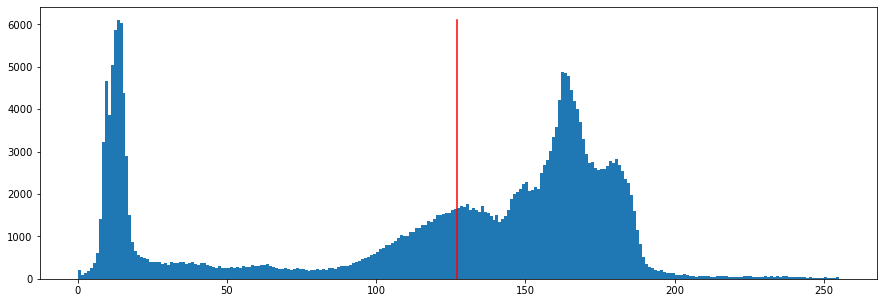

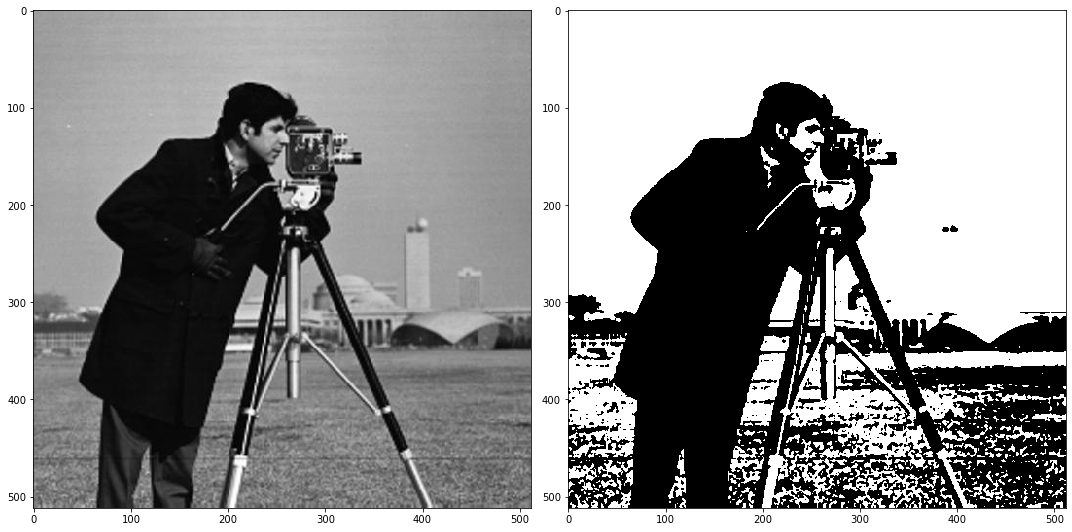

In [430]:
im = imread('camera.jpg')

T = 127 
im_segmented = manual_threshold(im, T)

plot_histogram_with_threshold(im, T)

# Show original image & segmented binary image
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
imshow(im)
plt.subplot(1,2,2)
imshow(im_segmented)
plt.show()

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

c:\Users\victo\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


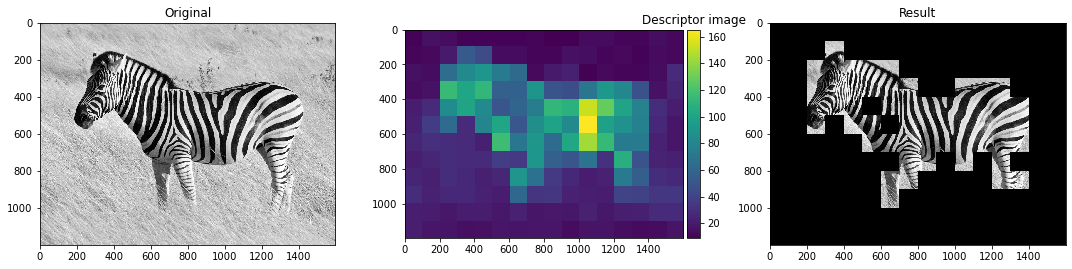

In [431]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops


def texture_descriptor(N):
    g = graycomatrix(N, [40], [0], levels=N.max()+1) # Replace with your descriptor
    e = graycoprops(g, prop='dissimilarity')
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(100,100))
T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

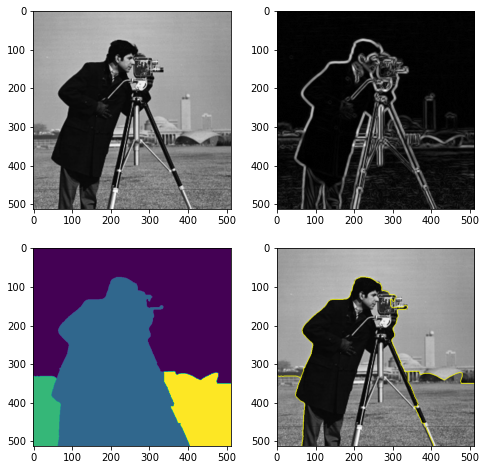

In [432]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

c:\Users\victo\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_18976\2351193644.py:30: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  markers_rgb = peak_local_max(grad.max()-grad, num_peaks=num_peaks, min_distance=min_distance, indices='indices')


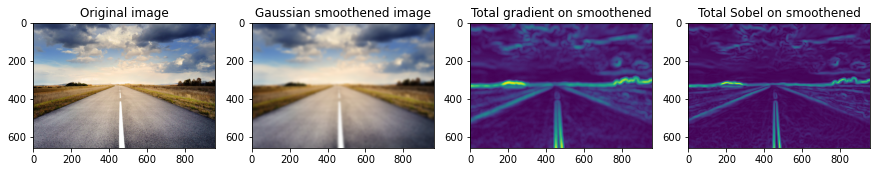

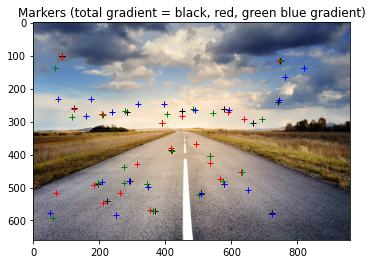

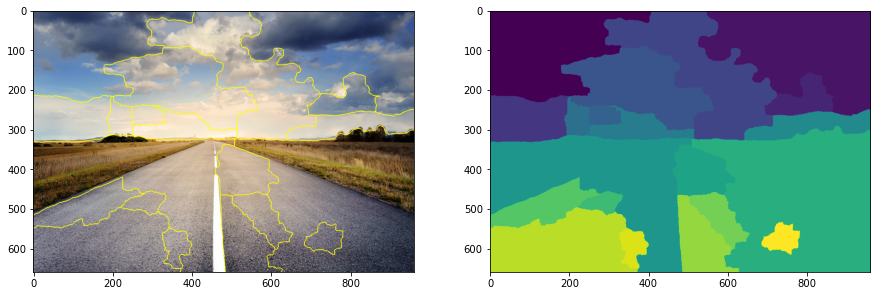

In [5]:
from skimage.morphology import disk
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread
from skimage.filters import rank, sobel, gaussian
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
 
im = imread('road.jpg')


# Your code here
def find_markers_rgb(im, gaussian_smoothing=5, disk_size=10, num_peaks = 20, min_distance = 50):
    im_smooth = gaussian(im, sigma=gaussian_smoothing)

    grad_r = rank.gradient(img_as_ubyte(im_smooth[:,:,0]), disk(disk_size)).astype('int')
    grad_g = rank.gradient(img_as_ubyte(im_smooth[:,:,1]), disk(disk_size)).astype('int')
    grad_b = rank.gradient(img_as_ubyte(im_smooth[:,:,2]), disk(disk_size)).astype('int')
    grad = grad_r + grad_g + grad_b

    # If you want to use sobel instead of gradient
    sob_r = sobel(im_smooth[:,:,0])
    sob_g = sobel(im_smooth[:,:,1])
    sob_b = sobel(im_smooth[:,:,2])
    sob = sob_r + sob_g + sob_b


    markers_rgb = peak_local_max(grad.max()-grad, num_peaks=num_peaks, min_distance=min_distance, indices='indices')
    markers_r = peak_local_max(grad_r.max()-grad_r, num_peaks=num_peaks, min_distance=min_distance)
    markers_g = peak_local_max(grad_g.max()-grad_g, num_peaks=num_peaks, min_distance=min_distance)
    markers_b = peak_local_max(grad_b.max()-grad_b, num_peaks=num_peaks, min_distance=min_distance)

    plt.figure(figsize=(15,10))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(im_smooth)
    plt.title('Gaussian smoothened image')
    plt.subplot(1,4,3)
    plt.imshow(grad)
    plt.title('Total gradient on smoothened')
    plt.subplot(1,4,4)
    plt.imshow(sob)
    plt.title('Total Sobel on smoothened')
    plt.show()

    plt.figure()
    plt.imshow(im)
    plt.plot(markers_rgb[:,1], markers_rgb[:,0], 'k+')
    plt.plot(markers_r[:,1], markers_r[:,0], 'r+')
    plt.plot(markers_g[:,1], markers_g[:,0], 'g+')
    plt.plot(markers_b[:,1], markers_b[:,0], 'b+')
    plt.title('Markers (total gradient = black, red, green blue gradient)')
    plt.show()
    return markers_rgb, grad



markers_coordinates, grad = find_markers_rgb(im)
markers_ = np.zeros_like(grad)
for i,(row,col) in enumerate(markers_coordinates):
    markers_[row,col] = i+1

markers_ = label(markers_)

ws = watershed(grad, markers=markers_)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(im, ws))
plt.subplot(1,2,2)
plt.imshow(ws)
plt.show()


Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

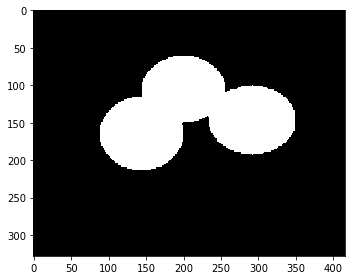

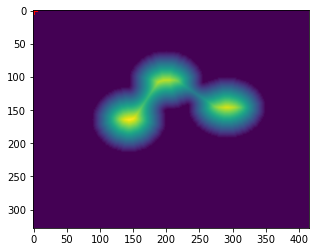

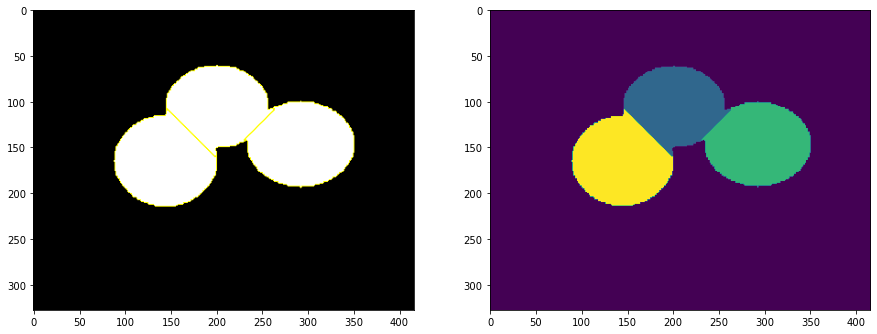

In [434]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.feature import peak_local_max

im = rgb2gray(imread('separ.png'))==0
imshow(im)

# Your code here
distance = distance_transform_edt(im)

markers_coordinates = peak_local_max(distance, min_distance=10)
markers_ = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers_[row,col] = i+1

plt.figure()
plt.imshow(distance)
plt.plot(markers[:,1], markers[:,0], 'r+')
plt.show()

markers_ = label(markers_)
ws = watershed(im,markers=markers_, mask=im)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(im, ws))
plt.subplot(1,2,2)
plt.imshow(ws)
plt.show()


**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

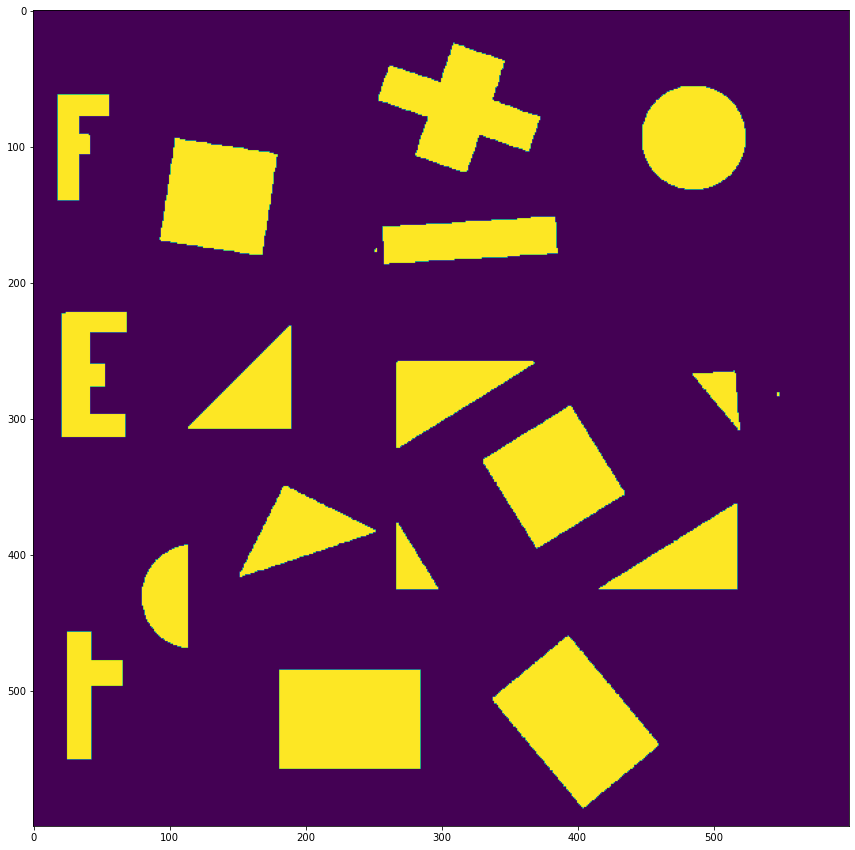

In [42]:
from skimage.measure import label, regionprops,find_contours

im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

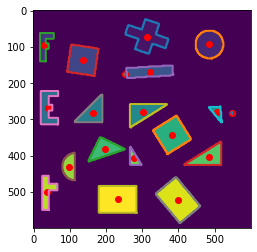

In [81]:

# Your code here
labels = label(im)


properties = regionprops(labels)

contours = find_contours(im)

plt.figure()
plt.imshow(labels)
plt.plot([round(p['centroid'][1]) for p in properties], [round(p['centroid'][0]) for p in properties], 'ro')
for shape in range(len(contours)):
    plt.plot([round(c[1]) for c in contours[shape]], [round(c[0]) for c in contours[shape]], linewidth=2)
plt.show()


**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

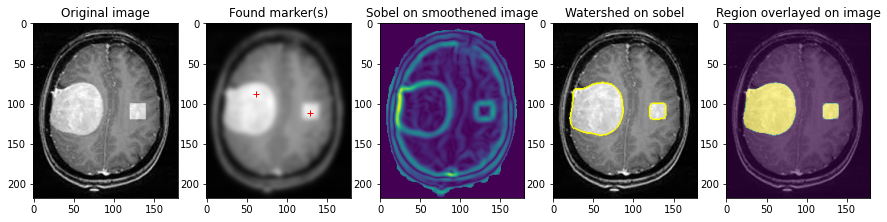

Number of tumor(s) observed: 2
Estimated tumor area: 444 cm^2 (~14% of head slice)


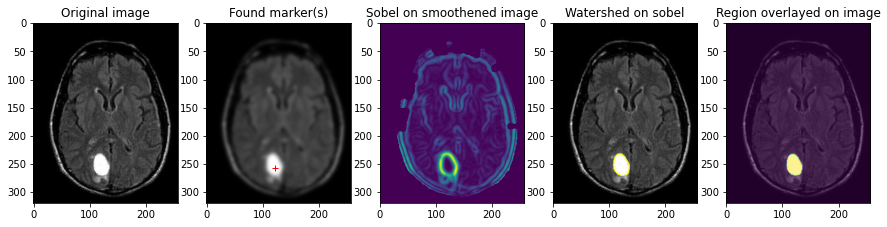

Number of tumor(s) observed: 1
Estimated tumor area: 94 cm^2 (~2% of head slice)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
from skimage.morphology import opening, closing, disk
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.segmentation import mark_boundaries, watershed
from skimage.filters import sobel, gaussian

#load file, 3 channels are the same so converted to 1
im = imread('mri_brain.jpg')[:,:,0].astype('uint16')
# MRI found on internet to test if method works on new picture
im2 = imread('internet_tumor.png').astype('uint16')
# Can also detect multiple tumors, first create artificial picture
im_2_tumors = im.copy()
im_2_tumors[100:120,120:140] = im[100:120,50:70]


def brainmask(im):
    # Remove black background pixels
    background_mask = im>15
    # Smoothen with 
    background_mask = opening(closing(background_mask, disk(5)), disk(5))
    return background_mask


def tumorfinder(im, gaussian_smoothing=3, num_peaks = 1, min_distance = 30):

    # Determine head region (filter background)
    brain_mask = brainmask(im)

    # Smoothen image to remove noise
    im_smooth = gaussian(im, sigma=gaussian_smoothing)
    
    # Get local maxima of smoothened image
    marker_coordinates = peak_local_max(im_smooth, num_peaks=num_peaks, min_distance=min_distance)
    
    # Convert markers in correct format (same size as im)
    markers_ = np.zeros_like(im)
    for i,(row,col) in enumerate(marker_coordinates):
        markers_[row,col] = i+1
    # Add marker for background region
    markers_[10,10] = 1
    markers_ = label(markers_)

    # Perform watershed on sobel of smoothened image, only on head region
    sob = sobel(im_smooth, mask=brain_mask)
    ws = watershed(sob, markers=markers_)

    # Calculate area
    tumor_area = round(np.count_nonzero(ws != 1)*0.115)
    tumor_relative_area = round(100*(tumor_area/(0.115*brain_mask.sum())))

    # Plot intermediate steps and result
    plt.figure(figsize=(15,10))
    plt.subplot(1,5,1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.title('Original image')
    plt.subplot(1,5,2)
    plt.imshow(im_smooth, cmap=plt.cm.gray)
    plt.plot(marker_coordinates[:,1], marker_coordinates[:,0], 'r+')
    plt.title('Found marker(s)')
    plt.subplot(1,5,3)
    plt.imshow(sob)
    plt.title('Sobel on smoothened image')
    plt.subplot(1,5,4)
    plt.imshow(mark_boundaries(im.astype('uint8'), ws))
    plt.title('Watershed on sobel')
    plt.subplot(1,5,5)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.imshow(ws>1, alpha= 0.5)
    plt.title('Region overlayed on image')
    plt.show()

    # Print results
    print(f'Number of tumor(s) observed: {len(np.unique(ws))-1}\nEstimated tumor area: {tumor_area} cm^2 (~{tumor_relative_area}% of head slice)')
    return

# Call function
tumorfinder(im_2_tumors, gaussian_smoothing=3, num_peaks=2, min_distance = 30)
tumorfinder(im2, gaussian_smoothing=3, num_peaks=1, min_distance = 30)
